In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Simulation parameters
L = 125         # Length of the road
num_cars = 50   # Number of cars
num_lanes = 3   # Number of lanes
vmax = 5        # Maximum speed
p = 0.1         # Probability of random deceleration

def initialize_cars(N, L, num_lanes):
    '''
    Initialize car positions, velocities, lanes, and colors.
    Ensure no cars in lane 2 are initialized beyond position 10,
    and positions in lane 2 are unique.
    '''
    car_positions = np.sort(np.random.choice(range(L), N, replace=False))  # Ensure unique positions
    car_velocities = np.random.randint(1, vmax + 1, size=N)  # Random initial velocities between 1 and vmax
    car_lanes = np.random.choice(range(1, num_lanes), N)  # Randomly assign each car to a lane
    
    # Track used positions for lane 2 to ensure uniqueness
    used_positions_lane_3 = set()
    
    for i in range(N):
        if car_lanes[i] == 2:
            # Ensure position <= 10 and unique for lane 3
            while car_positions[i] in used_positions_lane_3:
                car_positions[i] = np.random.randint(0, 24)
            # Add to the set of used positions for lane 3
            used_positions_lane_3.add(car_positions[i])
    
    # Generate unique colors for each car
    car_colors = plt.cm.rainbow(np.linspace(0, 1, num_cars))
    
    return car_positions, car_velocities, car_lanes, car_colors


def next_distance(car_positions, car_lanes, pos, L):
    '''
    Finds the distance to the next car in the same lane.
    Handles unsorted car_positions.
    '''
    N = len(car_positions)
    current_lane = car_lanes[pos]
    current_position = car_positions[pos]
    
    # Filter cars in the same lane
    same_lane_cars = [(car_positions[i], i) for i in range(N) if car_lanes[i] == current_lane]
    
    # Sort positions in the lane circularly
    same_lane_cars.sort(key=lambda x: (x[0] - current_position) % L)
    
    # The first car in sorted order (excluding itself) is the next car
    for position, index in same_lane_cars:
        if index != pos:
            distance = ((position - current_position - 1) % L)
            return distance
    
    return L  # Max distance if no car is in front in the same lane


def update_velocity(car_positions, car_velocities, car_lanes, vmax, p):
    '''
    Update velocities of cars based on traffic rules.
    '''
    N = len(car_positions)

    truth = False
    inlane3 = []   

    for j in range(N):
        if car_lanes[j] == 2 and car_positions[j] > 25:
            truth = True
        if car_lanes[j] == 0 or car_lanes[j] == 1 or truth == True:
            inlane3.append(j)
            # Step 1: Acceleration
            for i in inlane3:
                if car_velocities[i] < vmax:
                    distance_to_next = next_distance(car_positions, car_lanes, i, L)
                    if distance_to_next > car_velocities[i]:
                        car_velocities[i] += 1

            # Step 2: Deceleration
            for i in inlane3:
                distance_to_next = next_distance(car_positions, car_lanes, i, L)
                if car_velocities[i] > distance_to_next:
                    car_velocities[i] = distance_to_next

            # Step 3: Randomisation
            for i in inlane3:
                if np.random.rand() < p:
                    car_velocities[i] = max(car_velocities[i] - 1, 0)

            # Step 4: If velocity is at 0 and there is no car in front, increase velocity to 1 as no point being standstill on motorway
            for i in inlane3:
                distance_to_next = next_distance(car_positions, car_lanes, i, L)
                if car_velocities[i] == 0 and distance_to_next > vmax:
                    car_velocities[i] = 1
        elif car_lanes[j] == 2 and car_positions[j] < 25:
            distance_to_next = next_distance(car_positions, car_lanes, j, L) 
            car_velocities[j] = min(distance_to_next, 1)
        elif car_lanes[j] == 2 and car_positions[j] == 25:
            car_velocities[j] = 0
        else:
            # Step 1: Acceleration
            for i in range(N):
                if car_velocities[i] < vmax:
                    distance_to_next = next_distance(car_positions, i, L)
                    if distance_to_next > car_velocities[i]:
                        car_velocities[i] += 1
        
            # Step 2: Deceleration
            for i in range(N):
                distance_to_next = next_distance(car_positions, i, L)
                if car_velocities[i] >= distance_to_next:
                    car_velocities[i] = distance_to_next
        
            # Step 3: Randomisation
            for i in range(N):
                if np.random.rand() < p:
                    car_velocities[i] = max(car_velocities[i] - 1, 0)

            # Step 4: If velocity is at 0 and there is no car in front, increase velocity to 1 as no point being standstill on motorway
            for i in range(N):
                distance_to_next = next_distance(car_positions, car_lanes, i, L)
                if car_velocities[i] == 0 and distance_to_next > vmax:
                    car_velocities[i] = 1

    return car_velocities

def apply_boundary_conditions(car_positions, car_velocities, car_lanes, L, target_lane=2, max_cars_in_target_lane=12):
    '''
    Remove cars that reach the end of the road and replace them with new cars.
    If there are fewer than max_cars_in_target_lane cars in target_lane, initialize the new car in that lane.
    '''
    # Count cars currently in the target lane
    cars_in_target_lane = sum(1 for lane in car_lanes if lane == target_lane)
    sorted_carpos, sorted_carvel, sorted_carlan = sort(car_positions, car_velocities, car_lanes)

    for i in range(len(car_positions)):
        if car_positions[i] >= L:  # Check if the car is beyond the boundary
            # Find the car in front to set a speed limit for the new car
            distance_to_next = next_distance(car_positions, car_lanes, i, L)
            front_car_velocity = sorted_carvel[(i + 1) % len(sorted_carvel)]
            new_velocity = np.random.randint(1, front_car_velocity + 1) if front_car_velocity > 0 else 1
            new_position = np.random.randint(0, min(distance_to_next, new_velocity)) if distance_to_next > 0 else 0

            # Decide the new lane for the car
            while cars_in_target_lane < max_cars_in_target_lane:
                new_lane = target_lane
                cars_in_target_lane += 1  # Increment count since we add a car to this lane
            else:
                new_lane = np.random.randint(0, num_lanes)  # Assign to a random valid lane

            # Replace the car with the new position, lane, and velocity
            car_positions[i] = new_position
            car_velocities[i] = new_velocity
            car_lanes[i] = new_lane

    return car_positions, car_velocities, car_lanes

# def apply_boundary_conditions(car_positions, car_velocities, car_lanes, L):
#     '''
#     Remove cars that reach the end of the road and replace them with new cars at position 0.
#     '''
#     sorted_carpos, sorted_carvel, sorted_carlan = sort(car_positions, car_velocities, car_lanes)
#     for i in range(len(car_positions)):
#         if car_positions[i] >= L:  # Check if car is beyond the boundary
#             # Find the car in front to set a speed limit for the new car
#             distance_to_next = next_distance(car_positions, car_lanes, i, L)
#             front_car_velocity = sorted_carvel[(i + 1) % len(sorted_carvel)]
#             new_velocity = np.random.randint(1, front_car_velocity + 1) if front_car_velocity > 0 else 1
#             new_position = np.random.randint(0, min(distance_to_next, new_velocity)) if distance_to_next > 0 else 0
#             # new_lane = np.random.randint(0, num_lanes)

#             # Replace the car with the new position, lane, and velocity
#             car_positions[i] = new_position
#             car_velocities[i] = new_velocity
#             # car_lanes[i] = new_lane

#     return car_positions, car_velocities, car_lanes


def update_positions(car_positions, car_velocities, car_lanes, L):
    '''
    Update car positions based on their velocities and apply boundary conditions.
    '''
    car_positions = (car_positions + car_velocities)  # Update positions
    car_positions, car_velocities, car_lanes = apply_boundary_conditions(car_positions, car_velocities, car_lanes, L)
    return car_positions, car_velocities, car_lanes  

def sort(car_positions, car_velocities, car_lanes):
    sorted_indices = np.argsort(np.abs(car_positions))
    
    sorted_carpos = car_positions[sorted_indices]
    sorted_carvel = car_velocities[sorted_indices]
    sorted_carlan = car_lanes[sorted_indices]

    return sorted_carpos, sorted_carvel, sorted_carlan

def separate_by_lane(car_positions, car_velocities, car_lanes, car_colors):
    lane_0_pos = []
    lane_0_vel = []
    lane_0_col = []
    lane_1_pos = []
    lane_1_vel = []
    lane_1_col = []
    lane_2_pos = []
    lane_2_vel = []
    lane_2_col = []

    for index, lane in enumerate(car_lanes):
        if lane == 0:
            lane_0_pos.append(car_positions[index])
            lane_0_vel.append(car_velocities[index])
            lane_0_col.append(car_colors[index])
        elif lane == 1:
            lane_1_pos.append(car_positions[index])
            lane_1_vel.append(car_velocities[index])
            lane_1_col.append(car_colors[index])
        elif lane == 2:
            lane_2_pos.append(car_positions[index])
            lane_2_vel.append(car_velocities[index])
            lane_2_col.append(car_colors[index])

    return lane_0_pos, lane_0_vel, lane_0_col, lane_1_pos, lane_1_vel, lane_1_col, lane_2_pos, lane_2_vel, lane_2_col

def find_surrounding_cars(lane_you_are_in, lane_you_could_be_in, i):    
    current_pos = lane_you_are_in[i]
    
    # Find the numbers in front and behind
    cars_front = [pos for pos in lane_you_could_be_in if pos > current_pos]
    cars_behind = [pos for pos in lane_you_could_be_in if pos < current_pos]
    
    # Get the closest in front and behind
    car_front = min(cars_front, default=None)  # None if no car is in front
    car_behind = max(cars_behind, default=None)     # None if no car is behind
    
    return car_front, car_behind


def find_surrounding_indices(lane_0_pos, lane_1_pos, i):
    if i < 0 or i >= len(lane_0_pos):
        raise IndexError("Index i is out of bounds for lane_0_pos")
    
    current_pos = lane_0_pos[i]
    
    # Find indices of numbers in front and behind
    indices_in_front = [idx for idx, pos in enumerate(lane_1_pos) if pos > current_pos]
    indices_behind = [idx for idx, pos in enumerate(lane_1_pos) if pos < current_pos]
    
    # Get the closest indices
    index_in_front = min(indices_in_front, key=lambda idx: lane_1_pos[idx], default=None)
    index_behind = max(indices_behind, key=lambda idx: lane_1_pos[idx], default=None)
    
    return index_in_front, index_behind


def lane_change(car_positions, car_velocities, car_lanes):
    '''
    Handle lane changes based on the safety and benefit criteria.
    Cars may change to a neighboring lane if it's safe and improves travel conditions.
    '''
    N = len(car_positions)
    
    for i in range(N):
        current_lane = car_lanes[i]
        current_pos = car_positions[i]
        current_velocity = car_velocities[i]

        if current_lane == 0:
            # Check neighboring lanes for lane change possibilities
            for delta_lane in [1]:  # Check lane -1 (left) and lane +1 (right)
                target_lane = current_lane + delta_lane

                if 0 <= target_lane < num_lanes:  # Ensure target lane is valid
                    # Get positions and velocities of cars in the target lane
                    target_lane_positions = car_positions[car_lanes == target_lane]
                    target_lane_velocities = car_velocities[car_lanes == target_lane]

                    # Find the closest car in front and behind in the target lane
                    cars_front = [pos for pos in target_lane_positions if pos >= current_pos]
                    cars_behind = [pos for pos in target_lane_positions if pos < current_pos]
                    car_front = min(cars_front, default=None)
                    car_behind = max(cars_behind, default=None)

                    # Calculate safety distances
                    safe_distance_front = float('inf') if car_front is None else car_front - current_pos
                    safe_distance_behind = -float('inf') if car_behind is None else current_pos - car_behind

                    # Get velocities of the closest cars
                    velocity_front = float('inf') if car_front is None else target_lane_velocities[np.where(target_lane_positions == car_front)[0][0]]
                    velocity_behind = -float('inf') if car_behind is None else target_lane_velocities[np.where(target_lane_positions == car_behind)[0][0]]

                    # can_move = [True for pos in target_lane_positions if safe_distance_behind + velocity_behind < current_velocity and safe_distance_front + velocity_front < current_velocity]

                    if (
                        safe_distance_behind < current_velocity + 1 and  # Enough space behind
                        safe_distance_front > current_velocity # Enough space in front
                    ):
                        car_lanes[i] = target_lane  # Change to the target lane
                        break  # Exit loop as lane change is complete
        else:
            # Check neighboring lanes for lane change possibilities
            for delta_lane in [-1]:  # Check lane -1 (left) and lane +1 (right)
                target_lane = current_lane + delta_lane

                if 0 <= target_lane < num_lanes:  # Ensure target lane is valid
                    # Get positions and velocities of cars in the target lane
                    target_lane_positions = car_positions[car_lanes == target_lane]
                    target_lane_velocities = car_velocities[car_lanes == target_lane]

                    # Find the closest car in front and behind in the target lane
                    cars_front = [pos for pos in target_lane_positions if pos >= current_pos]
                    cars_behind = [pos for pos in target_lane_positions if pos < current_pos]
                    car_front = min(cars_front, default=None)
                    car_behind = max(cars_behind, default=None)

                    # Calculate safety distances
                    safe_distance_front = float('inf') if car_front is None else car_front - current_pos
                    safe_distance_behind = -float('inf') if car_behind is None else current_pos - car_behind

                    # Get velocities of the closest cars
                    velocity_front = float('inf') if car_front is None else target_lane_velocities[np.where(target_lane_positions == car_front)[0][0]]
                    velocity_behind = -float('inf') if car_behind is None else target_lane_velocities[np.where(target_lane_positions == car_behind)[0][0]]

                    # can_move = [True for pos in target_lane_positions if safe_distance_behind + velocity_behind < current_velocity and safe_distance_front + velocity_front < current_velocity]

                    if (
                        safe_distance_behind < current_velocity + 1 and  # Enough space behind
                        safe_distance_front > current_velocity # Enough space in front
                    ):
                        car_lanes[i] = target_lane  # Change to the target lane
                        break  # Exit loop as lane change is complete

    return car_velocities, car_lanes

def step(car_positions, car_velocities, car_lanes, L, vmax, p):
    '''
    Perform a single time step update: update velocities, change lanes, and positions.
    '''
    car_velocities, car_lanes = lane_change(car_positions, car_velocities, car_lanes)
    car_velocities = update_velocity(car_positions, car_velocities, car_lanes, vmax, p)
    car_positions, car_velocities, car_lanes = update_positions(car_positions, car_velocities, car_lanes, L)
    return car_positions, car_velocities, car_lanes
 
 

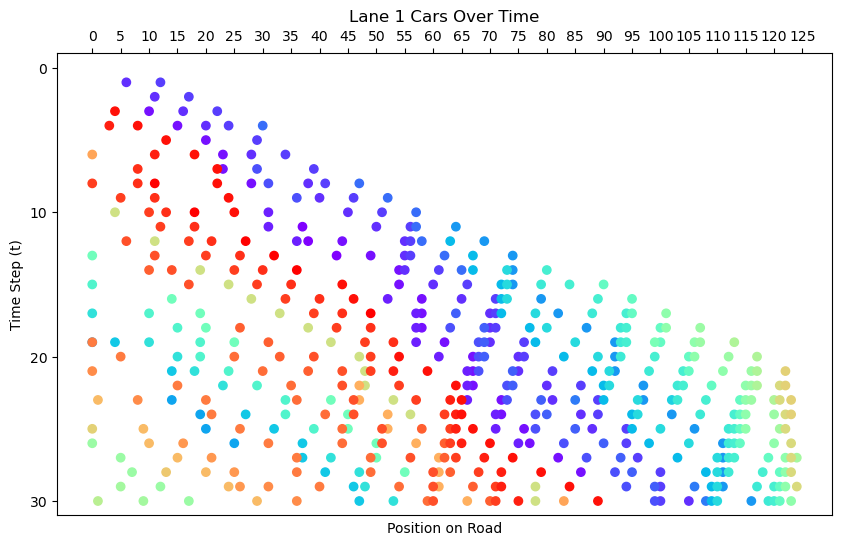

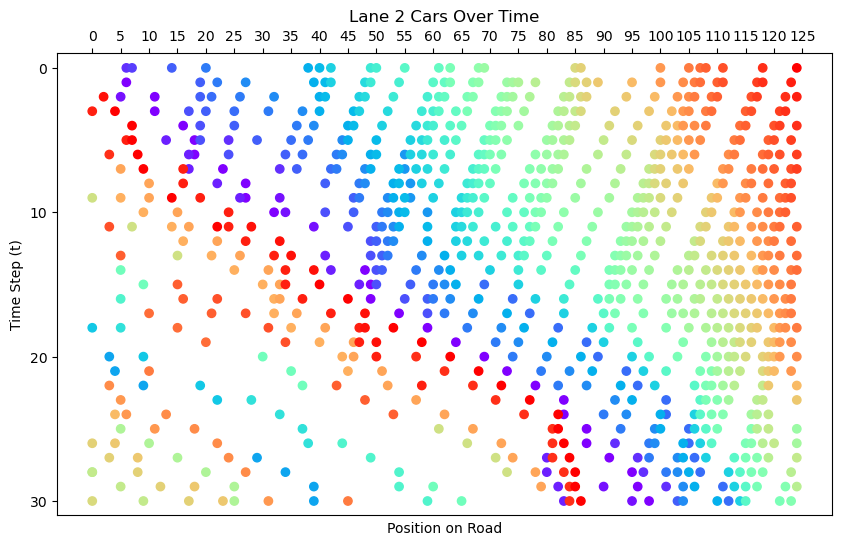

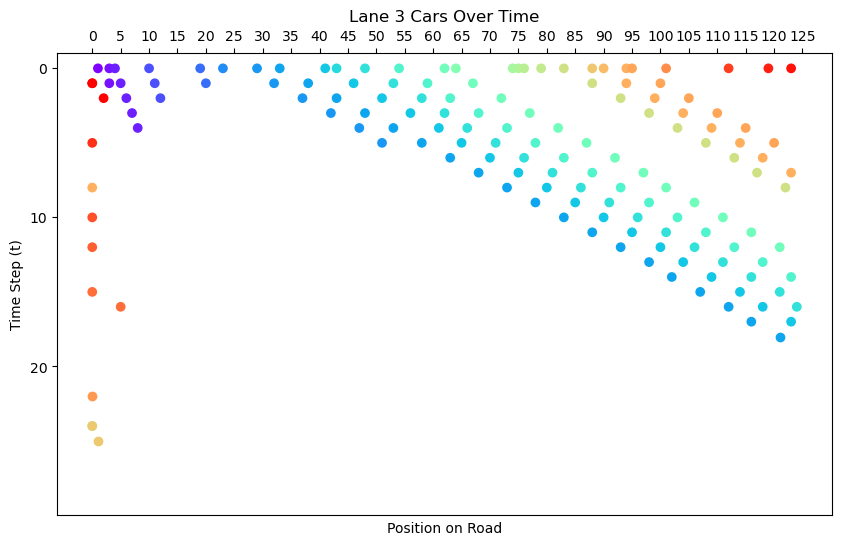

In [2]:
np.random.seed(1122)

lane_positions0 = []
lane_positions1 = []
lane_positions2 = []
lane_colors0 = []
lane_colors1 = []
lane_colors2 = []


car_positions, car_velocities, car_lanes, car_colors = initialize_cars(num_cars, L, num_lanes)
lane_0_pos, lane_0_vel, lane_0_col, lane_1_pos, lane_1_vel, lane_1_col, lane_2_pos, lane_2_vel, lane_2_col = separate_by_lane(car_positions, car_velocities, car_lanes, car_colors)
lane_positions0.append(lane_0_pos)
lane_colors0.append(lane_0_col)
lane_positions1.append(lane_1_pos)
lane_colors1.append(lane_1_col)
lane_positions2.append(lane_2_pos)
lane_colors2.append(lane_2_col)



def animate(i_step):
    global car_positions, car_velocities, car_lanes
    car_positions, car_velocities, car_lanes = step(car_positions, car_velocities, car_lanes, L, vmax, p)
    #car_positions, car_velocities, car_lanes = sort(car_positions, car_velocities, car_lanes)
    lane_0_pos, lane_0_vel, lane_0_col, lane_1_pos, lane_1_vel, lane_1_col, lane_2_pos, lane_2_vel, lane_2_col = separate_by_lane(car_positions, car_velocities, car_lanes, car_colors)
    lane_positions0.append(lane_0_pos)
    lane_colors0.append(lane_0_col)
    lane_positions1.append(lane_1_pos)
    lane_colors1.append(lane_1_col)
    lane_positions2.append(lane_2_pos)
    lane_colors2.append(lane_2_col)
    

# Number of steps to animate - Change this if you want for a longer timeframe
n_steps = 30

# car_positions, car_velocities, car_lanes, car_colors = initialize_cars(num_cars, L, num_lanes)

# Run the animation
for i_step in range(n_steps):
    animate(i_step)


# Plotting
plt.figure(figsize=(10, 6))
for t, positions in enumerate(lane_positions0):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors0[t])

plt.title("Lane 1 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.yticks(np.arange(0, n_steps+2, 10))
plt.xticks(np.arange(0, L+1, 5))
plt.ylim(n_steps+1, -1)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for t, positions in enumerate(lane_positions1):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors1[t])

plt.title("Lane 2 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.yticks(np.arange(0, n_steps+2, 10))
plt.xticks(np.arange(0, L+1, 5))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.ylim(n_steps+1, -1)
plt.savefig("25nohard")
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for t, positions in enumerate(lane_positions2):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors2[t])

plt.title("Lane 3 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.yticks(np.arange(0, n_steps, 10))
plt.xticks(np.arange(0, L+1, 5))
plt.ylim(n_steps, -1)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()